# Module 1, Notebook 1 - Wrangling ADNI Imaging and Outcome Data  






## Instructions

Please make a copy and rename it with your name (ex: Module1_NB1_Ilmi_Yoon). All grading points should be explored in the notebook but some can be done in a separate pdf file.

*Graded questions will be listed with "Q:" followed by the corresponding points.*

You will be submitting **a pdf** file containing **the url of your own Module1_NB1.**


---



# Introduction

## 1. Mounting and Accessing the Data

First we will load important packages below:

In [ ]:
import numpy as np
import os
from pathlib import Path
import glob
import pandas as pd
from collections import Counter
import math
from tqdm import tqdm

Because we are working on data stored in Google Cloud Storage bucket, the following steps will need to be taken:

1. Install gcsfuse it is a package used to mount the cloud bucket on to your local environment.
2. Authenticate your google account
3. Create a new directory to mount the storage bucket
4. Use gcsfuse to mount the storage bucket


In [ ]:
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v0.41.12/gcsfuse_0.41.12_amd64.deb; \
    dpkg --install gcsfuse_0.41.12_amd64.deb; \
    apt-get update; \
    apt-get clean;

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,430 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,471 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/univers

Now call google authentication with the following code block and allow access in the pop-up window

In [ ]:
from google.colab import auth
auth.authenticate_user()

We then need to set the project id and storage bucket id

In [ ]:
project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Updated property [core/project].


You can list using gsutil to see if we have the correct storage

In [ ]:
!gsutil ls

gs://csc-509-image-files/


In [ ]:
!mkdir images

Call gcsfuse to mount the bucket

In [ ]:
!gcsfuse --implicit-dirs csc-509-image-files images

2023/11/14 23:34:46.262009 Start gcsfuse/0.41.12 (Go version go1.18.4) for app "" using mount point: /content/images
2023/11/14 23:34:46.279671 Opening GCS connection...
2023/11/14 23:34:46.621721 Mounting file system "csc-509-image-files"...
2023/11/14 23:34:46.627973 File system has been successfully mounted.


In [ ]:
!ls images/

Archive  Module0_UPENNGBM  Module1_BraTS  Module1_BraTS.tar.bz2  Module2_ADNI  Module2_ADNI_New


## 2. Investigating the types of imaging data

In this section of the notebook, we will investgate the types of imaging data that are in the ADNI dataset.

Some brief background on ADNI:
* ADNI stands for the Alzheimer's Disease Neuroimaging Initiative and is a longstanding effort from many institutions around the country to amass a BIG imaging dataset that follows individuals for long periods of time
* It's been going on since 2004 and since then, the evolution of imaging technologies has advanced and therefore data like MRI and PET imaging have gotten better (and therefore different!) over time
* ADNI is the biggest public neuroimaging dataset for Alzheimer's (and maybe of all neurological diseases!)
* ADNI collects PET and MRI imaging for reasons described in detail in your lectures
* Due to the enormity of the data, it is hard to download and upload. It was a challenge to get the data for you! Though we worked hard to make sure you got some data from it, we currently have the MRI and PET data stored in two separate places: **The Module1_ADNI folder holds the PET data you will be using, and Module1_ADNI_New holds the MRI data you will be using**

We will start with investigating the MRI data, and building an example dataset to use for deep learning:

In [ ]:
DATA_PATH = 'images/Module2_ADNI_New/MRI/ADNI'

There are a few ways that you can look at whats inside of a folder, depending on whether you'd like to use a python "os" module (os standing for operating system) or whether you'd like to use the terminal/command line (using a "!" before something you'd type into the terminal). I'm showing you both ways below:

In [ ]:
os.listdir(DATA_PATH)[:10]

['002_S_0295',
 '002_S_0413',
 '002_S_0559',
 '002_S_0685',
 '002_S_0729',
 '002_S_0782',
 '002_S_0816',
 '002_S_0938',
 '002_S_0954',
 '002_S_1018']

In [ ]:
!ls {DATA_PATH} | head

002_S_0295
002_S_0413
002_S_0559
002_S_0685
002_S_0729
002_S_0782
002_S_0816
002_S_0938
002_S_0954
002_S_1018


So these look like unique patient identifiers, which I know because I've worked with many patient datasets before.

**Question (0.5 points)**: How many patients are in this dataset?

Pick a random patient and look into the data in their folder:

In [ ]:
first_patient = os.listdir(DATA_PATH)[0]
os.listdir(DATA_PATH+"/"+first_patient)

['Axial_PD_T2_FSE']

It looks like the folder inside the patient folder represents an MRI file. It has the words "axial" and "T2" which we have learned are associated with MRI.

Below, we investigate what the most common types of MRI are in the first 100 patients listed in the MRI folder:

In [ ]:
## Using glob.glob to use asterisks ("*") as wildcards to look inside folders at files
patient_folder_insides = glob.glob(os.path.join(DATA_PATH, '*', '*'))
print(patient_folder_insides[0])

images/Module2_ADNI_New/MRI/ADNI/002_S_0295/Axial_PD_T2_FSE


In [ ]:
## Since we have a lot of patients,
## and the i/o time on these colab notebooks isn't great,
## we want to just look at the first 100 patients and their MRI folders
## to get a sense of what's inside:

first_100 = patient_folder_insides[:100]

In [ ]:
## We can use a list comprehension (below) to look at only the last element
## of the file name when we split by the slashes in the full file path:
mri_sequences = [x.split('/')[-1] for x in first_100]
print(mri_sequences[0])
## We use the "Counter" function to count the instances of
## MRI sequences that are the same; that way we can find out how many
## Axial_PD_T2_FSE are in the first 100 patients for example:
Counter(mri_sequences).most_common()

Axial_PD_T2_FSE


[('MPRAGE', 17),
 ('Axial_PD_T2_FSE', 14),
 ('Field_Mapping', 14),
 ('Sagittal_3D_FLAIR', 10),
 ('Axial_T2_STAR', 9),
 ('Double_TSE', 8),
 ('HighResHippocampus', 7),
 ('Axial_3D_PASL__Eyes_Open_', 6),
 ('Axial_PD-T2_TSE', 6),
 ('Perfusion_Weighted', 4),
 ('Axial_3TE_T2_STAR', 4),
 ('Repeat_Axial_T2_STAR', 1)]

We notice that MPRAGE, Field Mapping, and Sagittal_3D_FLAIR are the most common types of MRI within the dataset. Thinking from a big-picture data science perspective, we'd be best off using the most common types of MRI that most of the patients have in their folders.
* MPRAGE is essentially a fancy kind of T1 MRI image. For our purposes, you don't need to know much more, but if you're interested, you can look [here](https://https://mriquestions.com/mp-rage-v-mr2rage.html) for more information!
* Field mapping is not very relevant for us - you can usually use it as a baseline for additional interesting scans, but we won't need it here.
* 3D FLAIR is the same T2-FLAIR that we discussed in class, but acquired in a slightly different way in the scanner, showing slightly different properties of the anatomy.
* You can see many also have a T2 FSE and T2 star image, which may be useful if needed, but that's still not in most of our patients. So we will ignore those for now.

Now we want to pick a patient that has a few different kinds of MRI. So here we'll list the patients with  4 or more folders inside:

In [ ]:
for patient in os.listdir(DATA_PATH)[:100]:
  if len(os.listdir(os.path.join(DATA_PATH, patient))) >= 4:
    print(patient, len(os.listdir(os.path.join(DATA_PATH, patient))))

002_S_6066 4
002_S_6404 4
003_S_6067 4
003_S_6092 4
003_S_6256 5
003_S_6259 4
003_S_6260 4
003_S_6264 4
003_S_6268 4
006_S_6234 4


# 3. Looking at a single patient's images
 In this section, we want to look at what an example patient's images might look like. We'll practice loading in the data and observing the differences between MRI series of the same patient.

Let's use the first patient and compare

In [ ]:
patient_id_test = '002_S_6066'
os.listdir(os.path.join(DATA_PATH, patient_id_test))

['Field_Mapping',
 'HighResHippocampus',
 'Perfusion_Weighted',
 'Sagittal_3D_FLAIR']

In [ ]:
image_type_to_test = 'Sagittal_3D_FLAIR'

In [ ]:
## Looking at the files, picking one of the descriptions above and looking at the file structure:
test_flair_image_path = os.path.join(DATA_PATH,patient_id_test,image_type_to_test)


**Question 2 (0.5 points):** What is the structure of the folders within the patient? Once you get to a file inside this patient, what kinds of folders are contained within?

In [ ]:
## Let's look at one of the files within this image type:
glob.glob(os.path.join(DATA_PATH, patient_id_test, image_type_to_test, "*", "*", "*"))[0]

'images/Module2_ADNI_New/MRI/ADNI/002_S_6066/Sagittal_3D_FLAIR/2017-08-16_06_50_17.0/I892218/ADNI_002_S_6066_MR_Sagittal_3D_FLAIR__br_raw_20170818100636582_85_S598532_I892218.dcm'

It appears to be a ".dcm" file, let's see how many there are inside:

In [ ]:
path_to_files = os.path.join(DATA_PATH, patient_id_test, image_type_to_test, "*", "*", "*")
files = glob.glob(path_to_files)
len(files)

160

These files all have the extension ".dcm", which means that it's a DICOM file. These types of files have both pixel data and meta-data associated with the pixel data (image). Therefore, they require a special reader in python. A quick google search will tell you to use pydicom, but Colab doesn't have that pre-installed. We'll install it below:

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.3 MB/s eta 0:00:00


In [ ]:
import pydicom
import matplotlib.pyplot as plt
import random

In [ ]:
random.seed(10)

Let's one of the DICOM images, I'll just pick a random one to read in from this folder:

In [ ]:
random_file = random.sample(files, 1)
random_file

['images/Module2_ADNI_New/MRI/ADNI/002_S_6066/Sagittal_3D_FLAIR/2017-08-16_06_50_17.0/I892218/ADNI_002_S_6066_MR_Sagittal_3D_FLAIR__br_raw_20170818100638848_116_S598532_I892218.dcm']

In [ ]:
first_dicom_dataset = pydicom.dcmread(random_file[0])

In [ ]:
## Looking at the components of a Dicom image/dataset:
first_dicom_dataset

/usr/local/lib/python3.10/dist-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '2.16.124.113543.6006.99.0296920128966594601'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '2.16.124.113543.6006.99.08537026053083405157'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 178
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.124.113543.6006.99.0296920128966594601
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.16.124.113543.6006.99.3688024390674402269
-------------------------------------------------
(0008, 0000) Group Length                        UL: 820
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS3D', 'DIS2D']
(0008, 0013) Instance Creation Time              TM: '070819.954000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.16.124.113

When you view the variable, you'll notice different numerical "tags". Each tag keeps a unique data field. Some important DICOM data fields for MRI images include:

*   Series Description
*   Pixel Data

You can usually find nearly any information you're looking for with respect to the image acqusition in these DICOM fields. Since some of these are manually input into the scanner, it is possible that the data field is subject to error. Let's access some of the tags and then look at the image:


In [ ]:

## If we want to know the manufacturer that this DICOM image was acquired at,
## you can access a tag by its numerical value like this:
first_dicom_dataset[0x8, 0x70]
## Note that we have to use 0x<number> format; otherwise Python won't know
## the 0s preceding the code exist.

(0008, 0070) Manufacturer                        LO: 'SIEMENS'

In [ ]:

## You can also use the name of the element:
first_dicom_dataset['Manufacturer']

(0008, 0070) Manufacturer                        LO: 'SIEMENS'

In [ ]:
## Or if you want the value only:
first_dicom_dataset.Manufacturer

'SIEMENS'

Now let's look at the image itself, which is located at the "pixel_array" element of the DICOM dataset:

In [ ]:
first_dicom_dataset.pixel_array.shape

(256, 256)

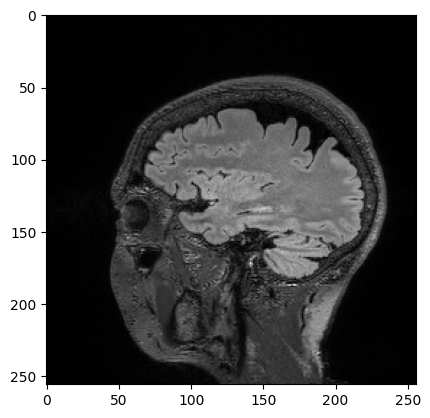

In [ ]:
plt.imshow(first_dicom_dataset.pixel_array, cmap = 'gray')

We notice that there is a number associated with the name of the random .dcm file that we picked; I have a hunch that this is the placement of the slice within the volume, aka slice number. We should confirm that this is the correct interpretation of the name. To do that, let's load the dicom slice datasets into a dictionary with the key as this identifier, then sort the keys & plot the slices:

In [ ]:
def read_all_dicom_slices(dicom_directory,
                         ):
  """
  Will read in the images from a single dicom folder and return a dictionary of
  those images with the key as the presumed slice number, and the value being the pixel array.

  dicom_directory: Path or string that leads to the folder containing the slices

  """
  dicom_image_dict = {}
  for image in glob.glob(dicom_directory):
    key = image.split('/')[-1].split('_')[-3]
    dicom_image_dict[key]= pydicom.dcmread(image)
  return dicom_image_dict

In [ ]:
first_dicom_volume = read_all_dicom_slices(path_to_files)

In [ ]:
def visualize_dicom_volume(dicom_volume: dict):
  """
  Takes a dicom volume, gives them the proper titles.
  dicom_volume,  e.g. {'1': <pixel_data>, ...}
  output is to plot an appropriate size image of the voulme that one is interested in.
  """
  num_rows = math.ceil(len(dicom_volume.keys())/5)
  keys_sorted = [str(x) for x in sorted([int(x) for x in list(dicom_volume.keys())])]
  plt.figure(figsize = (20, 15*num_rows))
  for i, key in enumerate(keys_sorted): # iterates through the dictionary, while the enumerate function keeps track of the index with i
      plt.subplot(5*num_rows,5,i+1)    # the number of images in the grid
      value = dicom_volume[key]
      img = value.pixel_array
      plt.imshow(img, cmap= 'gray')
      plt.axis('off')
      plt.title(key)
  plt.show()

In [ ]:
visualize_dicom_volume(first_dicom_volume)

Output hidden; open in https://colab.research.google.com to view.

This one is interesting! It doesn't say whether its T1 weighted or T2 weighted in the series description. Notice how the volume doesn't go through the whole brain, only the part containing the hippocampus (as it is named "HighResHippocampus").

* **Question 3 (0.5 points)** Load in and visualize the HighResHippocampus image in the volume. Is this a T1 or T2 weighted image?
* **Question 2 (0.5 points)** How can you tell?

# 4. Finding the center slices of all the MRI volumes:

In many biomedical imaging data science applications, you may not want to use the whole volume, but rather just a single slice of the volume. Of course, you would want the most representative slice, which is probably the middle slice of the volume. In that case, we'd need to find the middle slice somehow. Nifti volumes make it a bit easier.

Here with DICOM imaging, we need to use one of a few techniques in order to find the center slice. The following could work:
* Use the name of the DICOM image, as they all contain the slice. Pro would be that this is easy, the con being that often we can't trust file names as a source of truth.
* Use the DICOM metadata to figure out the geometric center of the volume, and then find the closest slice to that. Pro would be more accuracy, while the con is that the code is much more complicated, and loading in metadata definitely takes a lot longer than just looking at a filename.

In this example, we'll just use the filename.

Normally,  we could just use `glob` to get the all of the slices, but it's running too slow. Sometimes you might have to use creative techniques to get things to run faster, or at least see how long they will take. Here, we're using tqdm to show the status bar to see how long it will take:

In [ ]:
path_list_all_mri = []
for patient in tqdm(os.listdir(DATA_PATH)):
  patient_mri = glob.glob(os.path.join(DATA_PATH, patient, '*', '*', '*'))
  path_list_all_mri +=patient_mri

100%|██████████| 650/650 [03:28<00:00,  3.12it/s]


In [ ]:
path_list_all_mri[0]

'images/Module2_ADNI_New/MRI/ADNI/002_S_0295/Axial_PD_T2_FSE/2006-04-18_08_46_25.0/I13719'

In [ ]:

path_list_all_mri[:10]

['images/Module2_ADNI_New/MRI/ADNI/002_S_0295/Axial_PD_T2_FSE/2006-04-18_08_46_25.0/I13719',
 'images/Module2_ADNI_New/MRI/ADNI/002_S_0295/Axial_PD_T2_FSE/2006-04-18_08_46_25.0/I13724',
 'images/Module2_ADNI_New/MRI/ADNI/002_S_0413/Double_TSE/2006-05-19_16_40_10.0/I15804',
 'images/Module2_ADNI_New/MRI/ADNI/002_S_0559/Axial_PD_T2_FSE/2006-05-23_15_19_35.0/I15950',
 'images/Module2_ADNI_New/MRI/ADNI/002_S_0559/Double_TSE/2006-06-27_18_50_57.0/I17692',
 'images/Module2_ADNI_New/MRI/ADNI/002_S_0685/Axial_PD_T2_FSE/2006-07-06_10_54_55.0/I18208',
 'images/Module2_ADNI_New/MRI/ADNI/002_S_0685/Axial_PD_T2_FSE/2006-07-06_10_54_55.0/I18212',
 'images/Module2_ADNI_New/MRI/ADNI/002_S_0685/Axial_PD_T2_FSE/2006-07-06_11_02_11.0/I18209',
 'images/Module2_ADNI_New/MRI/ADNI/002_S_0729/Axial_PD_T2_FSE/2006-07-17_13_45_42.0/I19059',
 'images/Module2_ADNI_New/MRI/ADNI/002_S_0729/Double_TSE/2006-08-02_07_24_21.0/I20092']

In [ ]:
num_slices = len(os.listdir(path_list_all_mri[0]))
num_slices

56

In this part, we could get the middle slices for every single type of MRI, but we have already discussed that it is likely that things like field mapping won't be useful for any kind of analysis. It is also the case that localizers, etc. will not be useful. Here, since this is a computationally expensive procedure, it would be best to choose an MRI type of interest to get the middle slices. I will show you how to get the most common type of MRI, MPRAGE. But this can be done for any kind of MRI of interest.

In [ ]:
## Subset your path list down to any image with MPRAGE in the filename:
path_list_mprage = [x for x in path_list_all_mri if 'rage' in x.lower()]

In [ ]:
## Here, we want to go through the path list of uniform voxels and find the middle "center" slice of the volume
## and record the path to it:
middle_slices = []
for DATA_PATH in tqdm(path_list_mprage): # Using the tqdm package to show a status bar based on how quickly the process is running
  num_slices = len(os.listdir(DATA_PATH))
  middle_slice = str(num_slices//2)
  middle_slice_1 = str(num_slices//2+1)
  middle_slice_neg1 = str(num_slices//2-1)
  # print(middle_slice)
  if len(glob.glob(DATA_PATH+'/*_'+middle_slice+"_*")) > 0:
    middle_slices.append(glob.glob(DATA_PATH+'/*_'+middle_slice+"_*"))
  elif len(glob.glob(DATA_PATH+'/*_'+middle_slice_1+"_*")) > 0:
    middle_slices.append(glob.glob(DATA_PATH+'/*_'+middle_slice_1+"_*"))
  elif len(glob.glob(DATA_PATH+'/*_'+middle_slice_neg1+"_*")) > 0:
    middle_slices.append(glob.glob(DATA_PATH+'/*_'+middle_slice_neg1+"_*"))
  else: continue
    # print(DATA_PATH)

100%|██████████| 240/240 [02:21<00:00,  1.70it/s]


In [ ]:
len(middle_slices)

239

Creating a CSV file from these middle slices:

In [ ]:
DATA_PATH = Path('images/Module2_ADNI_New/MRI/ADNI')

In [ ]:
middle_slice_df = pd.DataFrame({'FILEPATH_MIDDLE_SLICES': [x[0] for x in middle_slices]})

In [ ]:
middle_slice_df.loc[0, 'FILEPATH_MIDDLE_SLICES']


'images/Module2_ADNI_New/MRI/ADNI/002_S_0729/MPRAGE/2006-08-02_07_02_00.0/I20088/ADNI_002_S_0729_MR_MPRAGE_br_raw_20070223050405652_85_S17535_I20088.dcm'

In [ ]:
middle_slice_df['SLICE_NUM'] = [x.split('_')[-3] for x in middle_slice_df.FILEPATH_MIDDLE_SLICES]
middle_slice_df.SLICE_NUM.value_counts()

80    174
85     47
92     18
Name: SLICE_NUM, dtype: int64

In [ ]:
middle_slice_df['MRI_TYPE'] = [x.split('/')[5] for x in middle_slice_df.FILEPATH_MIDDLE_SLICES]

In [ ]:
middle_slice_df['Subject'] = [x.split('/')[4] for x in middle_slice_df.FILEPATH_MIDDLE_SLICES]

In [ ]:

middle_slice_df.MRI_TYPE.value_counts()

MPRAGE    239
Name: MRI_TYPE, dtype: int64

In [ ]:

DATA_PATH

PosixPath('images/Module2_ADNI_New/MRI/ADNI')

In [ ]:
!ls images/Module2_ADNI_New/MRI/

ADNI  csvs


In [ ]:
os.makedirs(Path(DATA_PATH.parent, 'csvs'), exist_ok = True)

In [ ]:
middle_slice_df.to_csv(Path(DATA_PATH.parent, 'csvs', 'ADNI_MRI_MiddleSlices.csv'))

In [ ]:
middle_slice_df.head()


,FILEPATH_MIDDLE_SLICES,SLICE_NUM,MRI_TYPE,Subject
0,images/Module2_ADNI_New/MRI/ADNI/002_S_0729/MP...,85,MPRAGE,002_S_0729
1,images/Module2_ADNI_New/MRI/ADNI/002_S_0816/MP...,85,MPRAGE,002_S_0816
2,images/Module2_ADNI_New/MRI/ADNI/002_S_0954/MP...,85,MPRAGE,002_S_0954
3,images/Module2_ADNI_New/MRI/ADNI/002_S_0954/MP...,85,MPRAGE,002_S_0954
4,images/Module2_ADNI_New/MRI/ADNI/002_S_1018/MP...,85,MPRAGE,002_S_1018


We need to add the outcome data to make this a useful dataset!

In [ ]:
os.listdir(Path('images', 'Module2_ADNI_New', 'MRI', 'csvs'))

['ADNI_MRI_MiddleSlices.csv', 'clinical_data.csv', 'clinical_data1.csv']

In [ ]:
clin_data_df = pd.read_csv(Path('images', 'Module2_ADNI_New', 'MRI', 'csvs', 'clinical_data.csv'))

In [ ]:
unique_subjects_clin_data = clin_data_df.Subject.unique()

In [ ]:
len([x for x in middle_slice_df.Subject if x not in unique_subjects_clin_data])

56

In [ ]:
clin_data_df = clin_data_df[['Subject', 'Group']].drop_duplicates()

In [ ]:
middle_slice_df = pd.merge(middle_slice_df, clin_data_df, how= 'left', on = 'Subject' )

In [ ]:
middle_slice_df.to_csv(Path(DATA_PATH.parent, 'csvs', 'ADNI_MRI_MiddleSlices.csv'))

# Final thoughts

I showed you here how to create a middle slice dataset for MRI even though the next part of the module you will be creating a classifier using PET imaging. Note that this example was intentional because you will be asked in your assignment to do tasks related to both PET and MRI imaging. I believe this exercise will help you become familiar with MRI imaging for doing well on that assignment!

I hope you enjoyed learning about the MR data associated with the ADNI dataset. There will be a quiz on the AD biology and imaging!